<a href="https://colab.research.google.com/github/benmsanderson/transientio/blob/main/IO_transient_exiobase_fullecon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import stuff

In [2]:
import pymrio
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Set folders and load MRIO

In [3]:
save_folder_tr= './transition'

wiod = pymrio.load_all(save_folder_tr)

In [4]:
nreg=len(wiod.get_regions())

Define parameters - look at industrial output

In [38]:
wiod.x.head()

indout
region sector                     
Europe food           5.558382e+05
       mining         4.424582e+05
       manufactoring  7.607699e+06
       electricity    5.811623e+05
       gas            1.827506e+05

What are the units?

In [39]:
wiod.unit.head()

unit
region sector              
Europe food           M.EUR
       mining         M.EUR
       manufactoring  M.EUR
       electricity    M.EUR
       gas            M.EUR

# climate impacts
dummy numbers - impact is 10pct of production per kelvin

In [6]:
cfdb=wiod.x.copy()*-.1


In [36]:
cfdb.head()

indout
region sector                      
Europe food           -55583.819326
       mining         -44245.815890
       manufactoring -760769.882167
       electricity    -58116.232914
       gas            -18275.060499

Define climate parameters

In [10]:
#define TCRE
tcre=1.5 #K/Eg (10^18 kg)
#define timestep
ts=10 #years
#define climate impacts on economy
#cfdb=np.repeat(np.array([-4,-4,-4,-4,-4,-4,-4,-4.]),nreg)*100000 ##million EUR per K
#define final demand
fd=wiod.Y.sum(axis=1)#M.EUR



In [43]:
#define climate emissions factors
ef=wiod.impacts.F.iloc[[3]]/wiod.x.T.squeeze()*12/44/1e15 #Eg per million EUR

What are the units?

In [44]:
wiod.impacts.unit.iloc[[3]]

,unit
impact,
"GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)",kg CO2 eq.


Dummy numbers to define breakdown of total climate emissions (CO2e) to methane and CH4

In [45]:
fracch4=np.repeat(np.array([0.6,0.1,0.005,0,0.6,0,0,0]),nreg)
ef1=ef*(1-fracch4)
ef2=ef*fracch4

ef1

region                                                    Europe  \
sector                                                      food   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  1.462467e-10   

region                                                            \
sector                                                    mining   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  2.073539e-10   

region                                                            \
sector                                             manufactoring   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  1.976008e-11   

region                                                            \
sector                                               electricity   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  5.447645e-11   

region                                                            \
sector                                                       gas   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  6.749092e-11   

region                                                            \
sector                                              construction   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  6.393219e-12   

region                                                            \
sector                                                 transport   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  6.691449e-11   

region                                                            \
sector                                                     other   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  2.277754e-11   

region                                                      Asia  \
sector                                                      food   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  3.486665e-10   

region                                                            ...  \
sector                                                    mining  ...   
impact                                                            ...   
GHG emissions (GWP100) | Problem oriented appro...  4.927425e-10  ...   

region                                                    Africa  \
sector                                                 transport   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  4.116863e-11   

region                                                            \
sector                                                     other   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  1.194797e-10   

region                                                     Other  \
sector                                                      food   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  5.824887e-10   

region                                                            \
sector                                                    mining   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  4.043896e-10   

region                                                            \
sector                                             manufactoring   
impact                

In [46]:
wiod.get_sectors().tolist()

['food',
 'mining',
 'manufactoring',
 'electricity',
 'gas',
 'construction',
 'transport',
 'other']

# Make multi-index spanning all time periods

In [16]:
econ=wiod.get_sectors().tolist()#['sector1', 'sector2']
envr=['emisco2','emisch4','co2conc','ch4effect','T']

m2=pd.MultiIndex.from_product([['Impacts'],envr])
m1=wiod.get_index()
mu=m1.union(m2,sort=False)

_sectors = econ+envr
_regions = wiod.get_regions().tolist()#['reg1']
_times= np.arange(2000,2110,ts).astype('str')
#_Z_multiindex = pd.MultiIndex.from_product(
#                [_times, _regions, _sectors], names = [ u'times', u'region', u'sector'])
for i,t in enumerate(_times):
  print(i)
  # Convert index to dataframe
  old_idx = mu.to_frame()
  # Insert new level at specified location
  old_idx.insert(0, 'Year', t)
  # Convert back to MultiIndex
  muy = pd.MultiIndex.from_frame(old_idx)
  if i==0:
    _Z_multiindex=muy
  else:
    _Z_multiindex=_Z_multiindex.union(muy,sort=False)


0
1
2
3
4
5
6
7
8
9
10


In [58]:
# Convert index to dataframe
old_idx = mu.to_frame()
# Insert new level at specified location
old_idx.insert(0, 'Year', 2000)
# Convert back to MultiIndex
muy = pd.MultiIndex.from_frame(old_idx)

## Define A matrix for one time period

In [59]:

Y=wiod.A
A=np.identity(Y.shape[0])-Y
nsec=A.shape[0]

Af=A
Af.head()


region                  Europe                                                \
sector                    food    mining manufactoring electricity       gas   
region sector                                                                  
Europe food           0.901261 -0.003789     -0.030672   -0.001272 -0.000679   
       mining        -0.001481  0.927698     -0.028589   -0.018583 -0.061500   
       manufactoring -0.163872 -0.071712      0.709190   -0.061015 -0.083078   
       electricity   -0.014493 -0.016832     -0.013778    0.830412 -0.109213   
       gas           -0.002929 -0.001445     -0.003067   -0.092400  0.943860   

region                                                         Asia  \
sector               construction transport     other          food   
region sector                                                         
Europe food             -0.002994 -0.000475 -0.001470 -1.913487e-04   
       mining           -0.005599 -0.001111 -0.001053 -9.488402e-06   
       manufactoring    -0.132292 -0.055442 -0.044615 -2.577641e-03   
       electricity      -0.007842 -0.008561 -0.008751  0.000000e+00   
       gas              -0.001275 -0.000937 -0.001261 -3.515277e-11   

region                              ...        Africa                \
sector                      mining  ...     transport         other   
region sector                       ...                               
Europe food          -1.137537e-04  ... -1.797251e-04 -7.935582e-04   
       mining        -8.409673e-04  ... -3.896636e-06 -4.801432e-05   
       manufactoring -6.110582e-03  ... -2.072929e-02 -7.826896e-03   
       electricity    0.000000e+00  ...  0.000000e+00  0.000000e+00   
       gas           -2.044957e-09  ... -3.981424e-10 -2.037981e-09   

region                       Other                                            \
sector                        food        mining manufactoring   electricity   
region sector                                                                  
Europe food          -2.811888e-03 -8.490072e-05 -5.298222e-03 -3.030242e-04   
       mining        -1.501812e-05 -2.318251e-04 -1.844591e-03 -5.630766e-05   
       manufactoring -7.675120e-03 -8.444684e-03 -3.625308e-02 -1.035041e-02   
       electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       gas           -5.920633e-08 -1.929072e-08 -1.349942e-07 -1.076144e-07   

region                                                                        
sector                         gas  construction     transport         other  
region sector                                                                 
Europe food          -2.459029e-03 -2.355985e-04 -3.932072e-05 -5.220524e-04  
       mining        -2.236097e-04 -7.476424e-05 -6.676368e-06 -9.759177e-05  
       manufactoring -9.062744e-03 -2.558867e-02 -1.348106e-02 -1.070541e-02  
       electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
       gas           -9.725980e-08 -1.079395e-08 -5.941898e-09 -7.975053e-09  

[5 rows x 48 columns]

Define B matrix (elementary flows)

In [19]:

B=np.stack([ef1.to_numpy()[0], #co2 emissions by sector (GtC/trillion USD)
            ef2.to_numpy()[0], #ch4 emissions by sector (GtC/trillion USD)
            np.zeros(len(ef1.to_numpy()[0])), #cumulative emissions (CO2, GtC)
            np.zeros(len(ef1.to_numpy()[0])), #delta-cc (CH4, GtC)
            np.zeros(len(ef1.to_numpy()[0]))]) #net temperature (K)
Bf = pd.DataFrame(
    data = np.array(B),
    index = envr,
    columns = wiod.get_index()
    )
Bf

region           Europe                                            \
sector             food        mining manufactoring   electricity   
emisco2    1.462467e-10  2.073539e-10  1.976008e-11  5.447645e-11   
emisch4    2.193700e-10  3.110309e-10  2.964012e-11  8.171467e-11   
co2conc    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
ch4effect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
T          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

region                                                             \
sector              gas  construction     transport         other   
emisco2    6.749092e-11  6.393219e-12  6.691449e-11  2.277754e-11   
emisch4    1.012364e-10  9.589829e-12  7.434943e-12  2.530837e-12   
co2conc    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
ch4effect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
T          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

region             Asia                ...        Africa                \
sector             food        mining  ...     transport         other   
emisco2    3.486665e-10  4.927425e-10  ...  4.116863e-11  1.194797e-10   
emisch4    3.874072e-11  5.474917e-11  ...  0.000000e+00  0.000000e+00   
co2conc    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
ch4effect  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
T          0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   

region            Other                                            \
sector             food        mining manufactoring   electricity   
emisco2    5.824887e-10  4.043896e-10  1.836698e-10  1.479470e-09   
emisch4    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
co2conc    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
ch4effect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
T          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

region                                                             
sector              gas  construction     transport         other  
emisco2    2.058187e-10  3.495406e-11  1.497924e-10  6.124720e-11  
emisch4    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
co2conc    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
ch4effect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
T          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

[5 rows x 48 columns]

Define final demand matrix

In [60]:
mnum=A.shape[0]+B.shape[0]
f=np.zeros((1,mnum))
f[0,:(len(fd))]=fd.T #trillion USD
econb=econ.copy()
ff = pd.DataFrame(
    data = np.array(f),
    index = ['demand'],
    columns = mu
    )
ff

Europe                                             \
                 food        mining manufactoring    electricity   
demand  210947.896664  67787.706396  3.408493e+06  186428.945313   

                                                                 \
                 gas  construction      transport         other   
demand  52121.570895  2.874993e+06  887597.150466  6.938149e+06   

                 Asia                ...         Other               \
                 food        mining  ...   electricity          gas   
demand  478516.132595  25403.468006  ...  33766.263274  9279.300555   

                                                   Impacts                  \
         construction      transport         other emisco2 emisch4 co2conc   
demand  750645.256244  140913.883839  1.274447e+06     0.0     0.0     0.0   

                       
       ch4effect    T  
demand       0.0  0.0  

[1 rows x 53 columns]

C matrix - Characterisation factors/flows in environment





In [61]:
C=-1*np.identity(B.shape[0])
cf = pd.DataFrame(
    data = np.array(C),
    index = envr,
    columns = envr
    )
cf

,emisco2,emisch4,co2conc,ch4effect,T
emisco2,-1.0,-0.0,-0.0,-0.0,-0.0
emisch4,-0.0,-1.0,-0.0,-0.0,-0.0
co2conc,-0.0,-0.0,-1.0,-0.0,-0.0
ch4effect,-0.0,-0.0,-0.0,-1.0,-0.0
T,-0.0,-0.0,-0.0,-0.0,-1.0


D matrix - feedback flows

In [49]:
D=np.zeros((A.shape[0],B.shape[0]))
D[:,B.shape[0]-1]=cfdb.T #temperature effect on production M.EUR per K
D[:,B.shape[0]-2]=0 #methane concentration effect on production M.EUR per Eg CH4 (CO2e)
D[:,B.shape[0]-3]=0 #carbon concentration effect on production M.EUR per Eg C

df = pd.DataFrame(
    data = np.array(D),
    index = wiod.get_index(),
    columns = envr
    )
df.head()

emisco2  emisch4  co2conc  ch4effect              T
region sector                                                            
Europe food               0.0      0.0      0.0        0.0  -55583.819326
       mining             0.0      0.0      0.0        0.0  -44245.815890
       manufactoring      0.0      0.0      0.0        0.0 -760769.882167
       electricity        0.0      0.0      0.0        0.0  -58116.232914
       gas                0.0      0.0      0.0        0.0  -18275.060499

Build full X matrix

In [24]:


X=np.vstack((np.hstack((A,D)),np.hstack((B,C))))
xf = pd.DataFrame(
    data = np.array(X),
    index = mu,
    columns = mu
    )
xf

Europe                                            \
                               food        mining manufactoring   electricity   
Europe  food           9.012608e-01 -3.789466e-03 -3.067151e-02 -1.271837e-03   
        mining        -1.481020e-03  9.276975e-01 -2.858877e-02 -1.858320e-02   
        manufactoring -1.638717e-01 -7.171208e-02  7.091900e-01 -6.101503e-02   
        electricity   -1.449348e-02 -1.683231e-02 -1.377778e-02  8.304120e-01   
        gas           -2.929151e-03 -1.445423e-03 -3.067290e-03 -9.240021e-02   
        construction  -7.453683e-02 -3.686135e-02 -6.363399e-02 -4.849675e-02   
        transport     -2.264627e-02 -4.905780e-02 -4.123405e-02 -3.071343e-02   
        other         -5.525803e-02 -5.616551e-02 -8.260040e-02 -6.480969e-02   
Asia    food          -8.543714e-04 -1.355996e-05 -1.784509e-04 -6.957276e-06   
        mining        -1.275859e-05 -4.529812e-05 -1.119055e-04 -1.423543e-05   
        manufactoring -7.011542e-03 -2.900455e-03 -1.626590e-02 -2.492496e-03   
        electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        gas           -2.467189e-11 -1.561647e-09 -5.966187e-10 -3.541033e-09   
        construction  -6.927099e-04 -5.510830e-04 -9.444824e-04 -3.777215e-04   
        transport     -1.079195e-04 -4.216564e-04 -3.338078e-04 -5.552533e-04   
        other         -4.780769e-04 -4.903888e-04 -9.208904e-04 -4.405804e-04   
America food          -1.984915e-03 -3.092105e-05 -6.599920e-04 -1.546929e-05   
        mining        -6.088510e-05 -4.795775e-04 -2.000384e-03 -2.190393e-04   
        manufactoring -5.531545e-03 -1.562126e-03 -1.077388e-02 -1.932551e-03   
        electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        gas           -8.318530e-11 -2.324976e-09 -1.134771e-09 -1.143546e-08   
        construction  -5.251305e-04 -6.036018e-04 -8.613377e-04 -3.557587e-04   
        transport     -2.087174e-04 -7.067633e-04 -6.661978e-04 -4.706339e-04   
        other         -1.057171e-03 -7.449175e-04 -2.748271e-03 -9.755023e-04   
Oceania food          -6.200402e-05 -1.586985e-06 -1.632436e-05 -2.902667e-07   
        mining        -2.521559e-05 -3.970350e-05 -1.675817e-04 -2.134821e-05   
        manufactoring -1.108343e-04 -3.803545e-05 -4.952448e-04 -5.490791e-05   
        electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        gas            0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        construction  -8.996247e-05 -1.143285e-04 -1.126876e-04 -6.218845e-05   
        transport     -2.487893e-05 -5.159657e-05 -6.181192e-05 -6.969428e-05   
        other         -7.452154e-05 -6.421210e-05 -8.779142e-05 -5.086475e-05   
Africa  food          -3.950774e-03 -4.110424e-05 -6.309450e-04 -4.924562e-05   
        mining        -2.737008e-05 -6.869552e-04 -3.381368e-03 -1.748882e-03   
        manufactoring -1.692604e-03 -3.710294e-04 -2.948970e-03 -7.025387e-04   
        electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        gas           -7.074580e-11 -1.876070e-09 -4.298617e-09 -1.171822e-08   
        construction  -1.750432e-04 -1.768147e-04 -2.319828e-04 -1.103560e-04   
        transport     -1.119193e-04 -4.738248e-04 -2.874925e-04 -2.090008e-04   
        other         -1.655317e-04 -9.724423e-05 -1.328541e-04 -8.029100e-05   
Other   food          -2.646632e-03 -4.289515e-05 -6.003366e-04 -2.929563e-05   
        mining        -3.379661e-05 -1.732910e-03 -8.054942e-03 -5.091009e-04   
        manufactoring -5.919711e-03 -1.469494e-03 -9.635079e-03 -1.991268e-03   
        electricity    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        gas           -6.832740e-09 -1.491575e-07 -3.699165e-07 -9.503109e-07   
        construction  -1.353590e-03 -8.609336e-04 -1.708425e-03 -5.608030e-04   
        transport     -3.095726e-04 -8.469782e-04 -9.873656e-04 -7.156405e-04   
        other         -7.262119e-04 -5.669204e-04 -1.314826e

## Replicate X matrix for each time period

In [25]:
#A_r=la.block_diag(X,X,X,X)
A_r=sparse.block_diag([X for _ in enumerate(_times)]).A

Define lifetime of forcers, add off-diagonal terms to transaction matrix

In [26]:
for i,t in enumerate(_times):
  for j,tt in enumerate(_times):
    if i<=j:
      #timescale concentration ppols
      tmpco2=1*np.exp(-(int(tt)-int(t))/1000) #very slow decay of co2
      tmpch4=1*np.exp(-(int(tt)-int(t))/10) #rapid decay of ch4

      #transfer emissions to cumulative CO2
      A_r[j*mnum+nsec+2,i*mnum+nsec]=tmpco2 #Eg in atmosphere at time j per Eg emitted at time i 
      #transfer emissions to cumulative CO2
      A_r[j*mnum+nsec+3,i*mnum+nsec+1]=tmpch4 #Eg (CO2e100) in atmosphere at time j per Eg emitted at time i
      #co2 effect on temperature
      A_r[j*mnum+nsec+4,j*mnum+nsec+2]=tcre*ts #TCRE * timestep - warming (K) per Eg CO2 in atmoshpere 
      #ch4 effect on temperature
      A_r[j*mnum+nsec+4,j*mnum+nsec+3]=tcre*ts #TCRE * timestep - warming (K) per Eg CH4 (CO2e) in atmoshpere 

Build dataframe for interpretation

In [50]:
A_r.shape

(583, 583)

In [62]:
Z = pd.DataFrame(
    data = np.array(A_r),
    index = _Z_multiindex,
    columns = _Z_multiindex
    )
Z.head()

Year                           2000                                      \
0                            Europe                                       
1                              food    mining manufactoring electricity   
Year 0      1                                                             
2000 Europe food           0.901261 -0.003789     -0.030672   -0.001272   
            mining        -0.001481  0.927698     -0.028589   -0.018583   
            manufactoring -0.163872 -0.071712      0.709190   -0.061015   
            electricity   -0.014493 -0.016832     -0.013778    0.830412   
            gas           -0.002929 -0.001445     -0.003067   -0.092400   

Year                                                                  \
0                                                                      
1                               gas construction transport     other   
Year 0      1                                                          
2000 Europe food          -0.000679    -0.002994 -0.000475 -0.001470   
            mining        -0.061500    -0.005599 -0.001111 -0.001053   
            manufactoring -0.083078    -0.132292 -0.055442 -0.044615   
            electricity   -0.109213    -0.007842 -0.008561 -0.008751   
            gas            0.943860    -0.001275 -0.000937 -0.001261   

Year                                                   ...        2100       \
0                                  Asia                ...       Other        
1                                  food        mining  ... electricity  gas   
Year 0      1                                          ...                    
2000 Europe food          -1.913487e-04 -1.137537e-04  ...         0.0  0.0   
            mining        -9.488402e-06 -8.409673e-04  ...         0.0  0.0   
            manufactoring -2.577641e-03 -6.110582e-03  ...         0.0  0.0   
            electricity    0.000000e+00  0.000000e+00  ...         0.0  0.0   
            gas           -3.515277e-11 -2.044957e-09  ...         0.0  0.0   

Year                                                                    \
0                                                      Impacts           
1                         construction transport other emisco2 emisch4   
Year 0      1                                                            
2000 Europe food                   0.0       0.0   0.0     0.0     0.0   
            mining                 0.0       0.0   0.0     0.0     0.0   
            manufactoring          0.0       0.0   0.0     0.0     0.0   
            electricity            0.0       0.0   0.0     0.0     0.0   
            gas                    0.0       0.0   0.0     0.0     0.0   

Year                                              
0                                                 
1                         co2conc ch4effect    T  
Year 0      1                                     
2000 Europe food              0.0       0.0  0.0  
            mining            0.0       0.0  0.0  
            manufactoring     0.0       0.0  0.0  
            electricity       0.0       0.0  0.0  
            gas               0.0       0.0  0.0  

[5 rows x 583 columns]

Make transient final demand vector

In [52]:
f_r=np.tile(f,(1,len(_times))).T
_categories = ['final demand']
_fd_multiindex = pd.MultiIndex.from_product(
                 [ _categories], names = [ u'category'])
Y = pd.DataFrame(
    data=f_r,
    index = _Z_multiindex,
    columns = _fd_multiindex)

## Solve system

In [53]:
#solve for climate impacts
Ai=la.inv(Z)

Aif = pd.DataFrame(
    data=Ai,
    index = _Z_multiindex,
    columns = _Z_multiindex)

Apply system to demand

In [54]:
P=Ai.dot(Y)
_categories = ['output']
_o_multiindex = pd.MultiIndex.from_product(
                 [ _categories], names = [u'category'])
Pf = pd.DataFrame(
    data=P,
    index = _Z_multiindex,
    columns = _o_multiindex)

# Do some plots

Let's look at output for one sector

In [63]:
Pf.loc[(slice(None),['OECD','Other'],['electricity']), :].head()


/tmp/ipykernel_398/721654005.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  Pf.loc[(slice(None),['OECD','Other'],['electricity']), :].head()


,,category,output
Year,0,1,
2000,Other,electricity,135717.211020
2010,Other,electricity,139689.593407
2020,Other,electricity,143609.841283
2030,Other,electricity,147548.151259
2040,Other,electricity,151531.000697


/tmp/ipykernel_398/2327365793.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  ax = Pf.loc[(slice(None),slice(None),['food','manufacturing']), :].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(15, 10), layout=(2, 3))


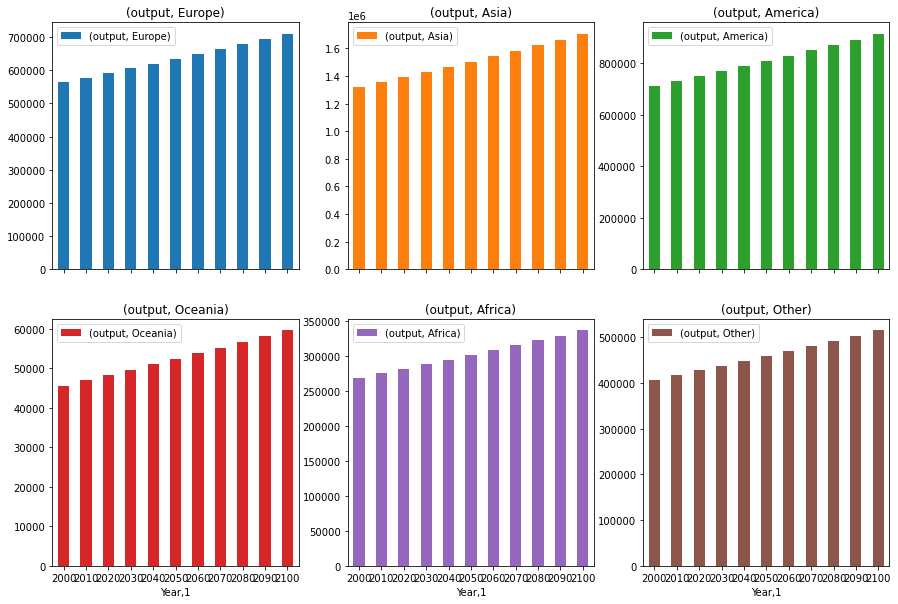

In [64]:
ax = Pf.loc[(slice(None),slice(None),['food','manufacturing']), :].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(15, 10), layout=(2, 3))
for axis in ax.flatten():
    axis.set_xticklabels(_times)





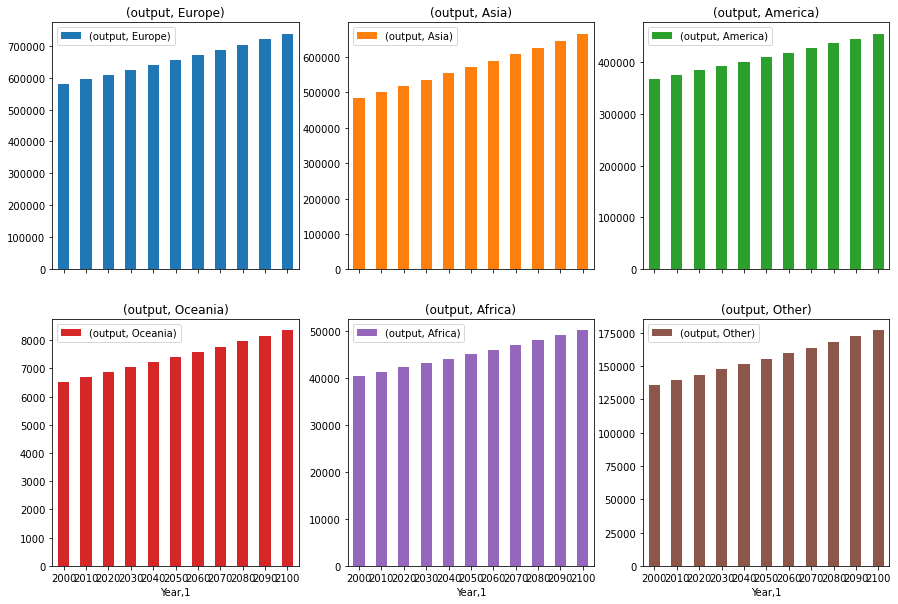

In [65]:
ax = Pf.loc[(slice(None),slice(None),['electricity']), :].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(15, 10), layout=(2, 3))
for axis in ax.flatten():
    axis.set_xticklabels(_times)





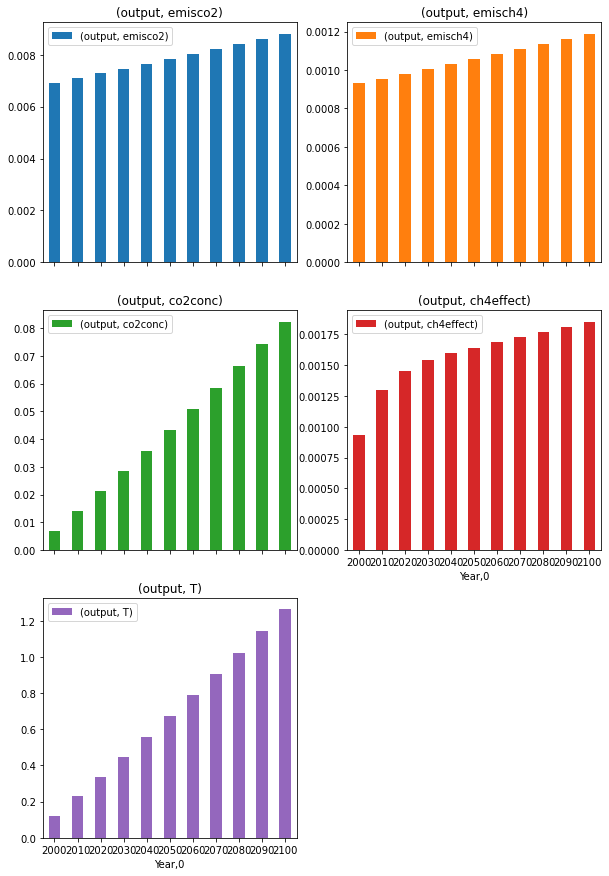

In [35]:
ax = Pf.loc[(slice(None),['Impacts'],slice(None)), :].unstack(level=2).plot(kind='bar', subplots=True, rot=0, figsize=(10, 15), layout=(3, 2))
for axis in ax.flatten():
    axis.set_xticklabels(_times)